## Collatz binary graph

In [109]:
"""
This experimental notebook analyses the binary representation of Collatz sequences from
a graph-theoretic perspective. It builds on a sample of sequences, stored in the csv file:
data/alpha_sequences.csv. The file can be generated by executing the script
run_alpha_export.py.
"""

# Imports
import sys
sys.path.append("..")

from pathlib import Path
import pandas as pd
from collatz import commons
import matplotlib.pyplot as plt
import networkx as nx


# Helper methods
def _to_binary(int_value):
    """
    This method returns the binary representation of
    a specific int value as string.
    :param int_value: The int value, if a str is handed
    over it is converted to an int.
    :return: The binary representation as string.
    """
    if type(int_value) == str:
        int_value = int(int_value)
    return commons.to_binary(int_value)


# Configuration
K_FACTOR = 3
EXPORT_DATA = False
DATA_PATH = Path.cwd().parent.as_posix() + "/data/"
INPUT_PATH = DATA_PATH + "alpha_export.csv"
EXPORT_PIC_PATH = DATA_PATH + "binary_graph.png"
EXPORT_CSV_PATH = DATA_PATH + "binary_graph.csv"
SHOW_LABELS = True

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Load data from csv
analysis_frame = pd.read_csv(
    INPUT_PATH, dtype={
        "v_i": object, "kv_i+1": object, "v_i+" : object,
        "v_1_bin" : str, "v_i_bin" : str})

# Filter data set
analysis_frame = analysis_frame[analysis_frame["k"] == K_FACTOR]

# Print meta data
sequence_count = int(analysis_frame["sequence_id"].nunique())

print("Collatz sequences loaded from file:", sequence_count, "\n")
print("Count of Collatz values:", len(analysis_frame), "\n")

# Derive additional features
analysis_frame["v_i_log2"].astype('int64') + 1

# Binary
max_bin_len = int(analysis_frame["bin_len"].max())
analysis_frame["bin_str"] = analysis_frame["v_i"].apply(_to_binary).str.zfill(max_bin_len)

analysis_frame["b2"] = analysis_frame["bin_str"].str[max_bin_len-2]
analysis_frame["b3"] = analysis_frame["bin_str"].str[max_bin_len-3]
analysis_frame["b4"] = analysis_frame["bin_str"].str[max_bin_len-4]
analysis_frame["b32"] = analysis_frame["b3"].astype('str') + analysis_frame["b2"]
analysis_frame["b432"] = analysis_frame["b4"].astype('str') + analysis_frame["b32"]

Collatz sequences loaded from file: 2000 

Count of Collatz values: 54814 



In [110]:
analysis_frame["predecessor"] = analysis_frame["b32"]
analysis_frame["successor"] = analysis_frame["predecessor"]
analysis_frame.loc[analysis_frame["terminal"] == True, ["predecessor"]] = "x"


predecessor = analysis_frame["predecessor"][:-1]
successor = analysis_frame["successor"][1:]
v_i = analysis_frame["v_i"][:-1]
v_ip = analysis_frame["v_i"][1:]
lambda_i = analysis_frame["l_i"][:-1]
alpha_i = analysis_frame["a_i"][:-1]
omega_i = analysis_frame["o_i"][:-1]

graph_frame = pd.DataFrame({
    "predecessor": list(predecessor),
    "successor": list(successor),
    "lambda_i": list(lambda_i),
    "alpha_i": list(alpha_i),
    "omega_i": list(omega_i)
})

graph_frame = graph_frame[graph_frame["predecessor"] != "x"]

edge_frame = graph_frame.groupby(["predecessor", "successor"])["lambda_i"].count().reset_index()
edge_frame.columns = ["predecessor", "successor", "count"]
edge_frame["weight"] = edge_frame["count"] / edge_frame["count"].sum()
edge_frame["width"] = edge_frame["weight"] * 25

print("Edges:\n")
print(edge_frame, "\n")

print("Nodes:\n")
print(graph_frame.groupby(["predecessor"])[["lambda_i", "alpha_i", "omega_i"]].mean())

Edges:

   predecessor successor  count    weight     width
0           00        00   2817  0.053338  1.333453
1           00        01   2457  0.046522  1.163044
2           00        10   4098  0.077593  1.939827
3           00        11   3335  0.063146  1.578653
4           01        00   7153  0.135438  3.385939
5           01        10   5652  0.107017  2.675427
6           10        00   2238  0.042375  1.059378
7           10        01   2012  0.038096  0.952399
8           10        10   4304  0.081494  2.037339
9           10        11   4001  0.075756  1.893911
10          11        01   7836  0.148370  3.709244
11          11        11   6911  0.130855  3.271386 

Nodes:

             lambda_i   alpha_i   omega_i
predecessor                              
00           1.526481  2.000000 -0.473519
01           1.542444  1.000000  0.542444
10           1.677897  3.726483 -2.048586
11           1.640808  1.000000  0.640808


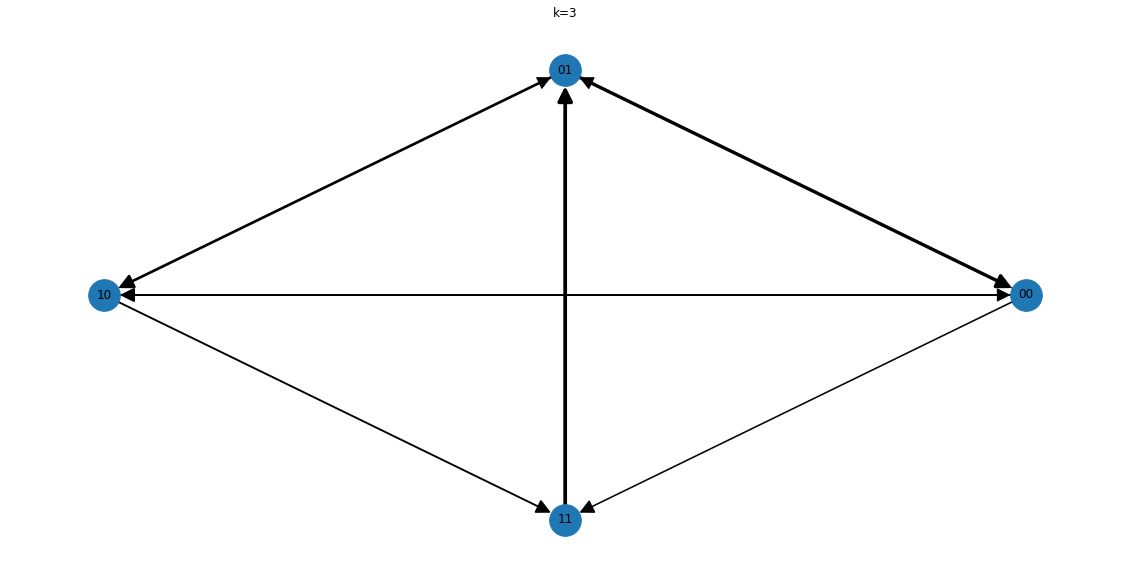

In [111]:
# Plot Graph
plt.figure(figsize=(20,10))
plt.title("k=" + str(K_FACTOR))

network = nx.convert_matrix.from_pandas_edgelist(
    edge_frame, source="predecessor", target="successor",
    create_using=nx.DiGraph(), edge_attr=True)

edges = network.edges()
widths = [network[u][v]['width'] for u,v in edges]

pos = nx.circular_layout(network)
nx.draw(network, pos, node_size=1000, with_labels=SHOW_LABELS,
        arrows=True, arrowsize=30, width=widths)

# Export data
if EXPORT_DATA:
    plt.savefig(EXPORT_PIC_PATH)
    edge_frame.to_csv(EXPORT_CSV_PATH, index=False)

# Show graph
plt.show()

if EXPORT_DATA:
    print("Graph saved:" + EXPORT_PIC_PATH)
